<a href="https://colab.research.google.com/github/NaimaZouidi/Frenshi-chatbot/blob/main/Frenshi_chatbot.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Frenshi Chatbot

This notebook trains a chatbot called Frenshi on the Administrative formalities in France for foreign students to help them during their stay!

# Set-up enviroment
To run this colab you will need to import some python modules such as Tensorflow, pandas, etc.



In [134]:
import tensorflow as tf
import json
import pandas as pd
import string
import numpy as np
import matplotlib.pyplot as plt
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.layers import Input, Embedding, LSTM, Dense, GlobalAvgPool1D, Flatten
from tensorflow.keras.models import Model
from sklearn.preprocessing import LabelEncoder

# Preparing Data set
In order to train Frenshi we need to create a dataset, a json file here, which will hold questions and the best answers to these questions.


In [140]:
%%writefile datasetFR.json
{"intents":
[{
      "tag": "greeting",
      "input": ["Salut", "Bonjour", "Bonsoir"],
      "responses" : ["Bienvenue! Je suis Frenshi! je suis là pour vous aider et accompagner dans vos démarches administratives en france. Les démarches administratives sont souvent un vrai casse-téte, d'autant plus pour les étudiants étrangers arrivant dans un nouveau pays. Mais ne vous inquiétez pas! Je suis là pour vous! Pour commenencer veuillez choisir parmi les propositions suivantes:\nCAF, titre de sèjour ou sècuritè Sociale",
      "Bonjour! Je suis Frenshi! je suis là pour vous aider et accompagner dans vos démarches administratives en france. Les démarches administratives sont souvent un vrai casse-téte, d'autant plus pour les étudiants étrangers arrivant dans un nouveau pays. Mais ne vous inquiétez pas! Je suis là pour vous! Pour commenencer veuillez choisir parmi les propositions suivantes:\nCAF, titre de sèjour ou sècuritè Sociale",
      "Bonsoir! Je suis Frenshi! je suis là pour vous aider et accompagner dans vos démarches administratives en france. Les démarches administratives sont souvent un vrai casse-téte, d'autant plus pour les étudiants étrangers arrivant dans un nouveau pays. Mais ne vous inquiétez pas! Je suis là pour vous! Pour commenencer veuillez choisir parmi les propositions suivantes:\nCAF, titre de sèjour ou sècuritè Sociale"]
    },
    {
     "tag": "goodbye",
     "input": ["Merci beaucoup! Au revoir", "Oh! Merci beaucoup", "Merci beaucoup! Bonne journée", "Merci beaucoup! Bonne journée"],
     "responses" : ["Au revoir! N'hesitez pas à revenir vers moi si vous avez d'autres questions concernant vos démarches admininstratives en France!",
     "Je t'en prie! N'hesitez pas à me poser d'autres question si vous avez besoin d'aide ou d'assistance dans vos démarches admininstratives en France!",
     "Bonne journée! N'hesitez pas à revenir vers moi si vous avez d'autres questions concernant vos démarches admininstratives en France!",
     "Bonne soirée! N'hesitez pas à revenir vers moi si vous avez d'autres questions concernant vos démarches admininstratives en France!"]
     },
    {
      "tag": "titre de sejour",
      "input":["Titre de sejour", "Pièces justificatives", "Etat Civile", "Photographie d'identité récente", "e-photo", "Motif de votre sèjour", "Demarche de titre de sejour"],
      "responses": ["Le titre de sèjour est un document qui vous permet de circuler et franchir les frontières de l'espace Schengen. En tant qu'étudiant étranger vous devez demander un titre de sèjour mention étudiant ou chercheur si vous étes venu faire une thèse de doctorat.",
      "Voici la liste des pièces justificatives que vous aurez besoin pour la préparation de votre dossier de titre de sèjour:\n1- Etat Civile.\n3- Photographie d'identité récente datant de moins de 3 mois.\n4- Justificatifs de domicile datant d'au moins de 6 mois.\n5- Le motif de votre sèjour.\n6- Des ressources financieres.",
      "Pour l'état civile il vaut faut un titre de sèjour en cours de validitè, s'il s'agit d'un renouvellement, ou juste votre passeport. En effet, si vous n'avez pas de titre de sejour en cours de validité, veuillez joindre les pages de votre passeport relatives à l'état civil, aux dates de validité, aux cachets d'éntrée et aux visas y a compris ton visa long séjour VTS.",
      "La Photographie d'identité est representée par une e-photo datant de moins de 3 mois.",
      "L'e-photo est une photo d'identité dématérialisée avec une signature numérique.",
      "Pour le motif de votre sèjour il s'agit de fournir une certificat d'inscription ou justificatif de réinscription auprés de votre établissement d'enseignement supérieur.\nVous aurez aussi besoin de:\n1- Vos relevés de notes.\n2- Votre dernier diplôme obtenu.\n3- Une attestation de réussite s'il s'agit d'une renouvellement.\nSi la mention de titre de séjour qui vous soliciter est chercheur vous devez joindre également une convention d'acceuil de laboratoire de recherche dont laquelle vous allez éffectuer votre thèse de doctorat.",
      "Si vous souhaitez effectuer votre demarche de titre de sèjour vous pouvez précèder à travers le site internet du gouvernement français ci-dessous:\nhttps://administration-etrangers-en-france.interieur.gouv.fr/particuliers/#/"]
    },
    {
      "tag": "justificatifs de domicile",
      "input": ["Justificatifs de domicile", "Je suis locataire", "Je suis héberger à l'hotel", "Je suis héberger chez un particulier"],
      "responses": ["Le justificatif de domocile peut prendre plusieurs forme. Veuillez s'il vous plait me preciser si vous étes locataire, héberger à l'hotel ou chez un particulier. Merci!",
      "Si vous étes locataire, vous pouvez joindre un des justificatifs de domicile suivant:\n- Une facture d'électricité, gaz, eau, internet, fixe ou mobile. \n- Une copie du bail de location.\n- Une copie d'une quittance de loyer ou de taxe d'habitation.",
      "Si vous étes heberger à l'hotel, vous pouvez joindre un des justificatifs de domicile suivant:\n - Une attestation de l'hotel.\n- Une copie de votre facture du dernier mois.",
      "Si vous ètes héberger chez un particulier, vous pouvez joindre un des justificatifs de domicile suivant:\n- Une attestation de l'hèbergeant datée et signée.\n- Une copie de sa Carte d'Identité Nationale(CIN) ou de sa carte de sèjour.\n- Un justificatif de domicile de l'hebergeant si l'adresse inscrite sur son CIN n'est pas à jour."]
    },
    {
      "tag": "ressources financiers",
      "input":["Ressources financiers", "Je suis pris en charge par un tiers", "Je suis boursier", "Je suis salarié", "J'ai des ressources financieres suffisantes"],
      "responses" : ["Les resources financiers peut dependre de votre situation. Veuillez s'il vous plait me preciser si vous étes pris en charge par un tiers, boursier, salarié ou vous avez des resources financiers suffisantes pour vos études.",
      "Si vous étes pris en charge par un tiers, vous pouvez joindre les attestations suivantes:\n- Une attestation de la banque du tiers justifiant de la programmation de virements réguliers vers votre compte.\n- Une attestation sur l'honneur de versement des sommes permettant d'atteindre le montant requis de 615$/mois à joindre avec un justificatif d'identité du tiers.",
      "Si vous ètes boursier, vous pouvez joindre une attestation justificative selon votre situation. Si vous étes boursier dans votre pays d'origine vous aurez besoin d'une attestation de bourse de l'organisme payeur du pays d'origine. Sinon, vous devez fournir une attestation de financement de gouvernement francaise ou programme européen qui finance vos études.",
      "Si vous étes salarié, vous pouvez fournir vos trois derniéres fiches de paie.",
      "Si vous disposez des ressources financieres suffisantes vous devez fournir l'attestation bancaire de solde créditeur suffisant."]
    },
    {
      "tag": "sècurité sociale",
      "input": ["Sècurité sociale"],
      "responses": ["La sècurité sociale vous permet de bènèficier de la prise en charge de vos frais de santè durant votre séjour en France. Trois phases de dèmarches sont à prévoir."]
    },
    {
      "tag": "phase 1 securité sociale",
      "input": ["Phase 1", "Pièces justificatives", "IBAN", "RIB", "Etat civil"],
      "responses" : ["Durant cet phase, la sécurité sociale vous demande de saisir vos informations personnelles et de déposer les documents justificatifs afin de créer votre espace personnel.",
      "Les Pièces justificatives pour formuler votre demande de sécurité sociale sont les suivants:\n\n1- Votre titre de séjour.\n2- Une attestation de scolarité pour l'année universitaire en cours.\n3- Votre IBAN ou RIB pour toute remboursement des frais de santé en France.\n4- Des piéce d'état-civil nécessaire à la création de votre numéro d'identification, couramment appelé numéro de sécurité sociale.\n\nDes accords et conventions internationales peuvent prévoir d'autres justificatifs, reportez-vous au site internet Ameli ci-dessous puis au chapitre 'Autres documents pour votre inscription selon votre pays d'origine'.\n\nhttps://www.ameli.fr/llle-et-vilaine/assure/droits-demarches/etudes-stages/etudiant/vous-venez-etudier-en-france#text_77155",
      "L'IBAN ou International Banking Account Number est l’identifiant du compte bancaire répondant à la norme internationale ISO 13616. En France, il est composé de 27 caractères, commençant par FR suivi de 2 caractères puis des 23 chiffres de l’ancien RIB (code de l’établissement bancaire, code du guichet, n° de compte et la clé RIB).",
      "Le RIB ou Relevé d’Identité Bancaire est un document utilisé en France pour identifier le titulaire d’un compte bancaire et préciser quelles sont ses coordonnées bancaires. Grâce à ce document, vous pouvez communiquer à vos contreparties (émetteurs de virements, créanciers qui se font payer par prélèvement…) votre domiciliation bancaire afin de recevoir des virements ou régler certaines dépenses par prélèvement, par exemple.",
      "Les piéces d'état civil acceptées peuvent être:\n- une copie intégrale de l'acte de naissance.\n- un extrait d'acte de naissance avec filiation (ou toute piéce établie par un consulat).\n- un livret de famille.\n- un acte de mariage."]
    },
    {
      "tag": "phase 2 securité sociale",
      "input" : ["Phase 2", "Médecin traitant", "Complémentaire santé"],
      "responses" : ["Afin de garantir la bonne prise en charge de vos frais de santé en France, il est essentiel de télécharger votre attestation provisoire depuis votre espace personnel sur le site internet https://etudiant-etranger.ameli.fr. Cela vous permet de:\n\n- Déclarer un médecin traitant.\n- Adhérer à une complémentaire santé.",
      "Un médecin traitant est un médecin vous permettre d'avoir un meilleur suivi médical et des soins mieux remboursés par la sécurité sociale.",
      "La complémentaire santé sert à compléter vos remboursements de l'Assurance Maladie et diminuer votre reste à charge, qui est généralement de l'ordre de 30%."]
    },
    {
      "tag": "phase 3 securité sociale",
      "input": ["Phase 3", "Compte Ameli", "Carte Vitale", "mettre à jour sa carte vitale", "Application Ameli"],
      "responses": ["Dés l'obtention de votre numéro de sécurité sociale vous pouvez:\n- Télécharger votre attestation définitive depuis votre espace personnel sur le site https:\\etudiant-etranger.ameli.fr.\n- Recevez un formulaire à compléter et à renvoyer afin de demander votre carte Vitale.\n- Ouvrir un compte Ameli. \n- Télécharger l'application mobile du compte Ameli.",
      "Le compte Ameli permet de suivre vous remboursements, modifier vous informations personnelles, poser vos questions via ameliBot, qui présente le chatbot de l'Assurance Maladie.",
      "Votre carte Vitale contient tous les renseignements nécessaires au remboursement de vos frais de santé en France. En la présentant à votre médecin, vous avez ainsi l'assurance d'être automatiquement remboursé en une semaine, sans avoir besoin d'envoyer de feuille de soins. \n Attention: Il est nécessaire de mettre à jour votre carte vitale une fois par an!",
      "Pour mettre à jour votre carte vitale, veuillez vous rendre chez la pharmacie la plus proche de chez vous.",
      "L'application Ameli peut être télécharger à travers le google play store via le lien ci-dessous:\nhttps://play.google.com/store/apps/datasafety?id=fr.cnamts.it.activity&hl=fr&gl=US"]
    },
    {
      "tag": "CAF",
      "input": ["CAF", "APL", "Condition d'APL", "Calcul d'APL", "Demander l'APL", "Premier versement d'APL", "Pièces justificatives"],
      "responses": ["Les étudiants étrangers en France peuvent avoir des difficultés à louer un logement, particuliérement sur Paris ou les grandes villes universitaires. La Caisse d'Allocations Familiales (CAF) est un organisme française de droit privés, présent dans chaque département francaise qui verse certaines prestations destinées à lutter contre la pauvreté tel que le RSA ou la Prime d'activité, mais également des aides au logement tel que l'APL.",
      "L'APL n'est pas spécifiquement destinée aux étudiants, elle s'adresse à toutes personnes ayant de faibles revenus. La bonne nouvelle c'est que même si vous étes étudiant étranger vous pouvez prétendre à l'APL, cette aide peut faire toute la différence! Toutefois, vous devez vous acquitter de certaines condition obligatoires.",
      "Pour pretendre de l'APL il faut: \n - Habiter 8 mois minimum dans votre logement étudiant au cours de l'année. \n- Votre logement fait l'objet d'une convention par l'état comme les cités universitaires, les foyers HLM, les logement socials, etc.\nAttention : Si vos parents vivent également en France et percoivent des allocations familiales ces derniers peuvent se voir retirer cette prestation si vous faites une demande d'APL. La régle est la même pour les ressortissants français. De plus si vous habitez en colocation et que vous faites une demande d'APL, votre colocataire se verra dans l'obligatoire d'en faire également, s'il ne fait pas la demande d'APL cela peut impacter votre éligibilité.",
      "L'APL est calculée en fonction du montant du loyer, de vos ressources (revenus des parents, vos revenus, prestations familiales), son attribution n'est donc pas automatique, et son montant peut dépendre de votre situation.",
      "Les étudiants étrangers, comme les étudiants français doivent formuler leur demande en ligne sur le site internet de la caf ci-dessous:\nhttps://wwwd.caf.fr/wps/portal/caffr/aidesetdemarches/mesdemarches/faireunedemandedeprestation#DAL\n\nEn remplissant votre demande vous devez précisez que vous n'êtes pas allocataire, en effet, comme c'est votre premiére demande vous ne posséder pas d'espace personnel sur le site de la CAF. Donc il fault que vous créer un nouveau compte. Une fois que cela est fait vous pourrez vous connecter à votre compte CAF en ligne.",
      "Comme vous ne pourrez pas faire une demande d'APL qu'après votre emmènagement, vous recevez votre premier versement au moins un mois aprés votre emmènagement. Par exemple, Si vous emménagez au mois de septembre votre premier versement peut commencer seulement au début du mois d'octobre.",
      "Pour formuler votre demande d'APL vous devez obligatoirement avoir un compte bancaire français et donc fournir un RIB. Il vous faut également:\n1- Votre bail.\n2- Une attestation de domocile, rempli par le propriétaire du logement.\n3) Une justificatifs de vos revenus sur les deux derniéres années, vous pouvez fournir les déclarations de revenus de ces deux derniéres année de votre pays d'origine.\n4) Votre carte d'identité nationale ou passeport, ainsi que votre extrait d'acte de naissance avec une traduction certifiée en français.\n\nSi vous étes citoyen de l'UE vous devrez fournir une attestation d'inscription à l'université et votre carte d'assurance Européenne d'assurance maladie.\nSi vous étes non-européen vous devrez joindre un titre de séjour qui soit valide au minimum pour toute l'année universitaire en cours ainsi qu'un justificatif d'inscription au régime de la sécurité sociale étudiante Ameli."]
    },
    {
      "tag": "unknown",
      "input": ["cool", "blablabla"],
      "responses" : ["Désolée! mais je ne trouves pas des réponses à votre question. Veuillez s'il vous plait essayer les propositions suivantes:\nCAF, titre de sèjour ou sècuritè Sociale. Merci!",
      "Pardon! mais je n'ai pas pu trouver des réponses à votre question. Veuillez s'il vous plait essayer les propositions suivantes:\nCAF, titre de sèjour ou sècuritè Sociale. Merci!"]
    }
    ]
}

Overwriting datasetFR.json


# Importing Dataset

In [141]:
with open("datasetFR.json") as dbfr:
  dataFR = json.load(dbfr)

In [142]:
tags = []
inputs = []
responses = {}
for intent in dataFR["intents"]:
  responses[intent["tag"]] = intent["responses"]
  for line in intent["input"]:
    inputs.append(line)
    tags.append(intent["tag"])

Here we convert data to a dataframe with the following two columns:


```
inputs: the user question.
tags: the corresponding tag to the user question.
```





In [143]:
data = pd.DataFrame({"inputs":inputs,"tags":tags})

In [144]:
data.head(5)

,inputs,tags
0,Salut,greeting
1,Bonjour,greeting
2,Bonsoir,greeting
3,Merci beaucoup! Au revoir,goodbye
4,Oh! Merci beaucoup,goodbye


# Preprocessing
NLP models can't understand text accordengly. So we need to preprocess the user input or question by removing punctuation and converting it to lowercase.

In [145]:
data['inputs'] = data["inputs"].apply(lambda wrd:[ltrs.lower() for ltrs in wrd if ltrs not in string.punctuation])
data['inputs'] = data["inputs"].apply(lambda wrd: ''.join(wrd))

In [146]:
data.head(5)

,inputs,tags
0,salut,greeting
1,bonjour,greeting
2,bonsoir,greeting
3,merci beaucoup au revoir,goodbye
4,oh merci beaucoup,goodbye


# Tokenizing the dataset

In [147]:
#Tokenize the data
tokenizer = Tokenizer(num_words=2000);
tokenizer.fit_on_texts(data['inputs']);
train = tokenizer.texts_to_sequences(data['inputs'])
#Apply padding
x_train = pad_sequences(train)
#Encoding output to numeric data
labelEnc = LabelEncoder()
y_train = labelEnc.fit_transform(data['tags'])

In [148]:
input_shape = x_train.shape[1]
print(input_shape)

8


In [149]:
vocabulary = len(tokenizer.word_index)
print("The number of unique words is: ", vocabulary)
output_len = labelEnc.classes_.shape[0]
print("The output length is: ", output_len)

The number of unique words is:  81
The output length is:  11


# Creating the model to classifier the input data by tags

In [150]:
i = Input(shape=(input_shape))
x = Embedding(vocabulary + 1, 10)(i)
x = LSTM(10, return_sequences=True)(x)
x = Flatten()(x)
x = Dense(output_len, activation="softmax")(x)
model = Model(i, x)
model.summary()

Model: "model_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_4 (InputLayer)        [(None, 8)]               0         
                                                                 
 embedding_3 (Embedding)     (None, 8, 10)             820       
                                                                 
 lstm_3 (LSTM)               (None, 8, 10)             840       
                                                                 
 flatten_3 (Flatten)         (None, 80)                0         
                                                                 
 dense_3 (Dense)             (None, 11)                891       
                                                                 
Total params: 2551 (9.96 KB)
Trainable params: 2551 (9.96 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


In [151]:
model.compile(loss="sparse_categorical_crossentropy", optimizer="adam", metrics="accuracy")

In [152]:
history = model.fit(x_train, y_train, epochs = 200)

Epoch 1/200
2/2 [==============================] - 2s 14ms/step - loss: 2.3962 - accuracy: 0.1522
Epoch 2/200
2/2 [==============================] - 0s 11ms/step - loss: 2.3935 - accuracy: 0.1522
Epoch 3/200
2/2 [==============================] - 0s 12ms/step - loss: 2.3912 - accuracy: 0.1739
Epoch 4/200
2/2 [==============================] - 0s 13ms/step - loss: 2.3889 - accuracy: 0.1957
Epoch 5/200
2/2 [==============================] - 0s 13ms/step - loss: 2.3864 - accuracy: 0.1957
Epoch 6/200
2/2 [==============================] - 0s 20ms/step - loss: 2.3839 - accuracy: 0.1957
Epoch 7/200
2/2 [==============================] - 0s 13ms/step - loss: 2.3815 - accuracy: 0.1957
Epoch 8/200
2/2 [==============================] - 0s 12ms/step - loss: 2.3784 - accuracy: 0.1957
Epoch 9/200
2/2 [==============================] - 0s 14ms/step - loss: 2.3761 - accuracy: 0.2174
Epoch 10/200
2/2 [==============================] - 0s 13ms/step - loss: 2.3729 - accuracy: 0.2174
Epoch 11/200
2/2 [=

Model analysis

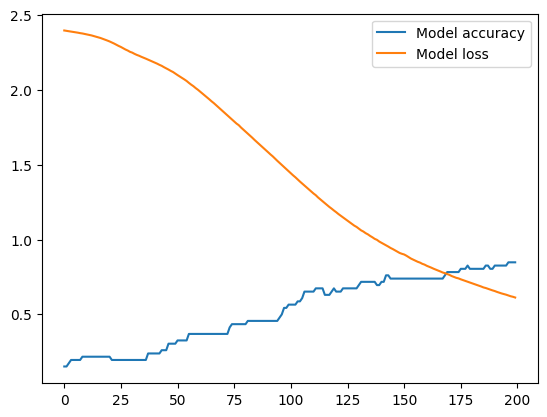

In [153]:
plt.plot(history.history['accuracy'], label = "Model accuracy")
plt.plot(history.history['loss'], label = "Model loss")
plt.legend()

# Testing frenshi


In [154]:
#chatting
import random
while True:
  texts_p = []
  prediction_input = input("You: ")
  #preprocessing the user data
  prediction_input = [ltrs.lower() for ltrs in prediction_input if ltrs not in string.punctuation]
  prediction_input = ''.join(prediction_input)
  texts_p.append(prediction_input)
  #tokenizing the user data
  prediction_input = tokenizer.texts_to_sequences(texts_p)
  prediction_input = np.array(prediction_input).reshape(-1)
  #Apply padding
  prediction_input = pad_sequences([prediction_input], input_shape)
  #
  output = model.predict(prediction_input)
  output = output.argmax()
  #convert model output to text
  response_tag = labelEnc.inverse_transform([output])[0]
  print("Frenshi: ", random.choice(responses[response_tag]))
  if response_tag == "goodbye":
    break

You: salut
1/1 [==============================] - 0s 480ms/step
Frenshi:  Bonjour! Je suis Frenshi! je suis là pour vous aider et accompagner dans vos démarches administratives en france. Les démarches administratives sont souvent un vrai casse-téte, d'autant plus pour les étudiants étrangers arrivant dans un nouveau pays. Mais ne vous inquiétez pas! Je suis là pour vous! Pour commenencer veuillez choisir parmi les propositions suivantes:
CAF, titre de sèjour ou sècuritè Sociale
You: CAF
1/1 [==============================] - 0s 25ms/step
Frenshi:  L'APL est calculée en fonction du montant du loyer, de vos ressources (revenus des parents, vos revenus, prestations familiales), son attribution n'est donc pas automatique, et son montant peut dépendre de votre situation.
You: APL
1/1 [==============================] - 0s 23ms/step
Frenshi:  Comme vous ne pourrez pas faire une demande d'APL qu'après votre emmènagement, vous recevez votre premier versement au moins un mois aprés votre emmèna

KeyboardInterrupt: Interrupted by user

In [126]:
output

NameError: name 'output' is not defined